##### Get data

In [1]:
!wget https://cloud.tsinghua.edu.cn/f/db9d627e4b5d4978973f/?dl=1

--2021-12-05 03:19:00--  https://cloud.tsinghua.edu.cn/f/db9d627e4b5d4978973f/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/04d8abe7-b287-433f-9ddb-1b3b29795a3a/dataset.zip [following]
--2021-12-05 03:19:02--  https://cloud.tsinghua.edu.cn/seafhttp/files/04d8abe7-b287-433f-9ddb-1b3b29795a3a/dataset.zip
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361875128 (345M) [application/zip]
Saving to: ‘index.html?dl=1’

index.html?dl=1     100%[===================>] 345.11M  11.4MB/s    in 33s     

2021-12-05 03:19:35 (10.6 MB/s) - ‘index.html?dl=1’ saved [361875128/361875128]



In [2]:
!mv index.html?dl=1 data.zip
!unzip data.zip

Archive:  data.zip
   creating: dataset/
   creating: dataset/0/
  inflating: dataset/0/0_0.png       
  inflating: dataset/0/1005_0.png    
  inflating: dataset/0/1029_0.png    
  inflating: dataset/0/1053_0.png    
  inflating: dataset/0/1077_0.png    
  inflating: dataset/0/1101_0.png    
  inflating: dataset/0/1125_0.png    
  inflating: dataset/0/1149_0.png    
  inflating: dataset/0/1173_0.png    
  inflating: dataset/0/1197_0.png    
  inflating: dataset/0/120_0.png     
  inflating: dataset/0/1221_0.png    
  inflating: dataset/0/1245_0.png    
  inflating: dataset/0/1269_0.png    
  inflating: dataset/0/1293_0.png    
  inflating: dataset/0/1317_0.png    
  inflating: dataset/0/1341_0.png    
  inflating: dataset/0/1365_0.png    
  inflating: dataset/0/1389_0.png    
  inflating: dataset/0/1413_0.png    
  inflating: dataset/0/1437_0.png    
  inflating: dataset/0/144_0.png     
  inflating: dataset/0/1460_0.png    
  inflating: dataset/0/1481_0.png    
  inflating: dataset/0/

##### Process dataset into dataloaders

We define several data augmentations such as rotations to increase our training data size.

In [15]:
import random

import cv2
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader


import torchaudio
import torchvision

class MelDataset(Dataset):
    def __init__(self, img_paths, augment=False, convert_to_rgb=True):     
        self.img_paths = img_paths
        self.augment = augment
        self.convert_to_rgb = convert_to_rgb
        self.labels = [int(path.split("_")[-1].split(".")[0]) for path in img_paths]
                  
    def __len__(self):
        return len(self.img_paths)

    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
          aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
          aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx], self.labels[idx]
        image = Image.open(img_path)
        # Duplicate the image across 3 channels to make it compatible with common pretrained model
        if self.convert_to_rgb:
            image = image.convert("RGB")
        image = torchvision.transforms.ToTensor()(image) / 255.0
        # Augmentation
        if self.augment:
            image = self.spectro_augment(image, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return image, torch.as_tensor(label, dtype=torch.long)


train_path = "/content/train/1.training/"
val_path = "/content/val/2.validation/img/"
val_mask_path = "/content/val/2.validation/mask/"

dataset_path = "/content/dataset"

train_split = 0.9 # 90% Train 
val_split = 0.1 # 10% Dev
# Optional test set:
#test_split = 0.05 # 5% Test

all_img_paths = []
for dir in os.listdir(dataset_path):
    for path in os.listdir(os.path.join(dataset_path, dir)):
        if ".png" in path:
            all_img_paths.append(os.path.join(dataset_path, dir, path))

random.shuffle(all_img_paths)

train_max_idx = int(train_split*len(all_img_paths))
val_max_idx = train_max_idx + int(val_split*len(all_img_paths))

train_paths = all_img_paths[:train_max_idx]
val_paths = all_img_paths[train_max_idx:]
#test_paths = all_img_paths[val_max_idx:]


train_dataset = MelDataset(img_paths=train_paths, augment=True)
val_dataset = MelDataset(img_paths=val_paths, augment=False)
#test_dataset = MelDataset(img_paths=test_paths, augment=False)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


dataloaders = {"train": train_dataloader, "val": val_dataloader, }#"test": test_dataloader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset),}# "test": len(test_dataset)}

print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'train': 2222, 'val': 247}


##### Data Exploration (EDA)

In this module we will take a quick look at the data to get an idea of its distribution.

In [16]:
from collections import Counter

print("Train Distribution: ", Counter(train_dataset.labels))
print("Val Distribution: ", Counter(val_dataset.labels))

Train Distribution:  Counter({13: 97, 20: 96, 1: 95, 18: 95, 16: 95, 2: 95, 7: 94, 0: 94, 15: 94, 3: 94, 14: 93, 5: 93, 22: 93, 11: 92, 9: 92, 10: 92, 12: 92, 17: 92, 6: 91, 8: 91, 4: 91, 21: 88, 19: 87, 23: 86})
Val Distribution:  Counter({19: 16, 23: 16, 21: 13, 8: 12, 4: 12, 6: 12, 10: 11, 12: 11, 11: 11, 9: 11, 5: 11, 14: 10, 17: 10, 22: 10, 0: 9, 15: 9, 7: 9, 3: 9, 1: 9, 18: 8, 2: 8, 20: 7, 16: 7, 13: 6})


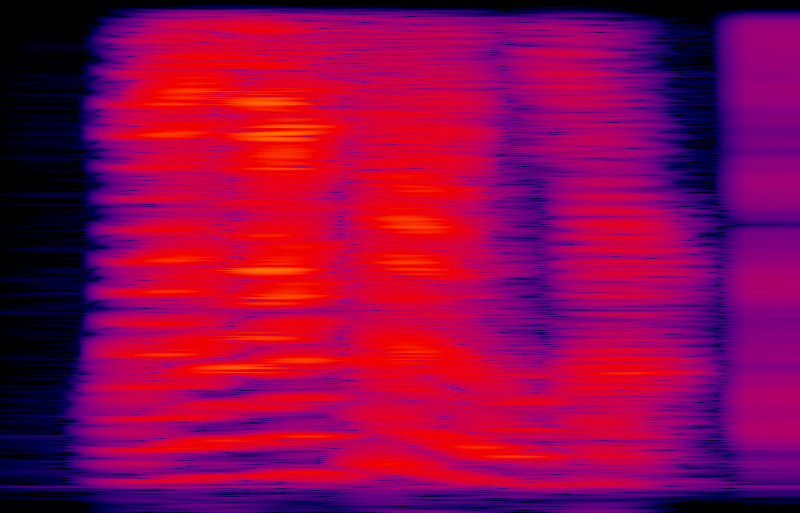

In [5]:
from PIL import Image
image = Image.open(train_paths[0])
image = image.convert("RGB") # Gray > RGB
image

In [6]:
import numpy as np
img_array = np.asarray(image)
print(img_array.shape, img_array[0,0,:])

(513, 800, 3) [0 0 0]


In [17]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([8, 1, 513, 800]), torch.Size([8]))

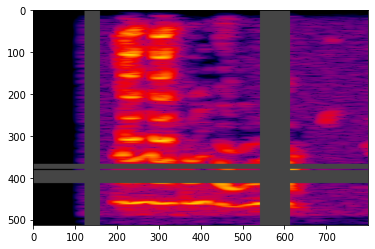

In [46]:
import matplotlib.pyplot as plt
tensor_image = image[0, ...] * 255
plt.imshow(  tensor_image.permute(1, 2, 0)  )

# Augmented example

##### Classification

In this sub-module we will classify the mel spectrogram.

In [ ]:
!pip install -q wandb

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class MelModel(torch.nn.Module):
    def __init__(self, num_labels, backbone=models.resnet18, freeze=True, lr=1e-4):
        super().__init__()
        self.backbone = backbone(pretrained=True)

        if freeze:
          # Only train final linear layer
          for param in self.backbone.parameters():
              param.requires_grad = False
          self.backbone.fc.requires_grad = True

        # Change last FC layer
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = torch.nn.Linear(num_ftrs, num_labels)

        if freeze:
            self.optimizer = torch.optim.SGD(self.backbone.fc.parameters(), lr=lr, momentum=0.9)
        else:
            # Optimize all parameters
            self.optimizer = torch.optim.SGD(list(self.backbone.parameters()), lr=lr, momentum=0.9)

    def forward(self, x):
        x = self.backbone(x)
        return x


criterion_clf = torch.nn.CrossEntropyLoss()

In [20]:
import copy
import time

from sklearn.metrics import f1_score

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, report_step=50, use_wandb=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_clf_loss, running_corrects, running_f1 = [], [], []

            # Iterate over data.
            for step, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(inputs)
                    _, preds = torch.max(pred.detach(), 1)
                    loss = criterion(pred, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # Scheduler will update every X steps as specified in its config
                        scheduler.step()

                # statistics
                running_clf_loss.append(loss.item() * inputs.size(0))
                running_corrects.extend((preds.detach() ==  labels.data).tolist())
                running_f1.extend([f1_score(preds.detach().cpu(), labels.detach().cpu(), average='weighted')])
  
                if (phase == 'train') and (step % report_step == 0):
                    report_clf_loss = sum(running_clf_loss) / len(running_clf_loss)
                    report_corrects = round(sum(running_corrects) / len(running_corrects), 4) * 100
                    report_f1 = round(sum(running_f1) / len(running_f1), 4) * 100

                    if use_wandb:
                        wandb.log({"loss": report_clf_loss, "acc": report_corrects, "f1": report_f1})
                    else:
                        print('{} Step: {} Loss: {:.4f} Accuracy: {:.2f}% F1 {:.2f}%'.format(phase, step, report_clf_loss, report_corrects, report_f1))
                    
                    running_clf_loss, running_corrects = [], []
            
            if phase == 'val':
                epoch_clf_loss = sum(running_clf_loss) / len(running_clf_loss)
                epoch_corrects = round(sum(running_corrects) / len(running_corrects), 4) * 100
                epoch_f1 = round(sum(running_f1) / len(running_f1), 4) * 100
                if use_wandb:
                    wandb.log({"val_loss": epoch_clf_loss, "val_acc": epoch_corrects, "val_f1": epoch_f1})
                else:
                    print('{} Step: {} Loss: {:.4f} Accuracy: {:.2f}% F1: {:.2f}%'.format(phase, step, epoch_clf_loss, epoch_corrects, epoch_f1))
                # deep copy the model
                if epoch_clf_loss < best_loss:
                    best_loss = epoch_clf_loss
                    best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [68]:
import numpy as np

# Hyperparameters
step_size = 200
gamma = 0.1
lr = 1e-4
freeze = False
use_wandb = True

if use_wandb:
    import wandb
    wandb.init(project='mel', entity='muennighoff')
    config = wandb.config
    config.freeze = freeze
    config.lr = lr
    config.gamma = gamma
    config.step_size = step_size

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MelModel(num_labels=len(set(train_dataset.labels)), freeze=freeze).to(device)

# Decay LR by a factor of 0.1 every 200 steps
optimizer_conv = model.optimizer

# Do not use scheduler
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=step_size, gamma=0.1)

class DummyScheduler:
    @staticmethod
    def step():
        pass
exp_lr_scheduler = DummyScheduler

model = train_model(model, criterion_clf, optimizer_conv,
                    exp_lr_scheduler, num_epochs=500, report_step=20, use_wandb=use_wandb)

acc,▁
f1,▁
loss,▁
acc,0.0
f1,0.0
loss,28.64832


Epoch 0/499
----------
Epoch 1/499
----------
Epoch 2/499
----------
Epoch 3/499
----------
Epoch 4/499
----------
Epoch 5/499
----------
Epoch 6/499
----------
Epoch 7/499
----------
Epoch 8/499
----------
Epoch 9/499
----------
Epoch 10/499
----------
Epoch 11/499
----------
Epoch 12/499
----------
Epoch 13/499
----------
Epoch 14/499
----------
Epoch 15/499
----------
Epoch 16/499
----------
Epoch 17/499
----------
Epoch 18/499
----------
Epoch 19/499
----------
Epoch 20/499
----------
Epoch 21/499
----------
Epoch 22/499
----------
Epoch 23/499
----------
Epoch 24/499
----------
Epoch 25/499
----------
Epoch 26/499
----------
Epoch 27/499
----------
Epoch 28/499
----------
Epoch 29/499
----------
Epoch 30/499
----------
Epoch 31/499
----------
Epoch 32/499
----------
Epoch 33/499
----------
Epoch 34/499
----------
Epoch 35/499
----------
Epoch 36/499
----------
Epoch 37/499
----------
Epoch 38/499
----------
Epoch 39/499
----------
Epoch 40/499
----------
Epoch 41/499
----------
Ep

KeyboardInterrupt: ignored

In [24]:
import torch.nn.functional as F
from torch.nn import init
from torch import nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self, num_labels):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=num_labels)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier(num_labels=len(set(train_dataset.labels)))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [25]:
# Reload data without converting to RGB

train_dataset = MelDataset(img_paths=train_paths, augment=True, convert_to_rgb=False)
val_dataset = MelDataset(img_paths=val_paths, augment=False, convert_to_rgb=False)
#test_dataset = MelDataset(img_paths=test_paths, augment=False)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {"train": train_dataloader, "val": val_dataloader, }#"test": test_dataloader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset),}# "test": len(test_dataset)}


lr = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myModel.parameters(),lr=lr)

# Do not use scheduling
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
#                                              steps_per_epoch=int(len(train_dataloader)),
#                                              epochs=10,
#                                              anneal_strategy='linear')


class DummyScheduler:
    @staticmethod
    def step():
        pass
scheduler = DummyScheduler


use_wandb = True
if use_wandb:
    import wandb
    wandb.init(project='mel', entity='muennighoff')
    config = wandb.config
    config.lr = lr

model = train_model(myModel, criterion, optimizer,
                    scheduler, num_epochs=500, report_step=20, use_wandb=True)

wandb: Currently logged in as: muennighoff (use `wandb login --relogin` to force relogin)


Epoch 0/499
----------
Epoch 1/499
----------
Epoch 2/499
----------
Epoch 3/499
----------
Epoch 4/499
----------
Epoch 5/499
----------
Epoch 6/499
----------
Epoch 7/499
----------
Epoch 8/499
----------
Epoch 9/499
----------
Epoch 10/499
----------
Epoch 11/499
----------
Epoch 12/499
----------
Epoch 13/499
----------
Epoch 14/499
----------
Epoch 15/499
----------
Epoch 16/499
----------
Epoch 17/499
----------
Epoch 18/499
----------
Epoch 19/499
----------
Epoch 20/499
----------
Epoch 21/499
----------
Epoch 22/499
----------
Epoch 23/499
----------
Epoch 24/499
----------
Epoch 25/499
----------
Epoch 26/499
----------
Epoch 27/499
----------
Epoch 28/499
----------
Epoch 29/499
----------
Epoch 30/499
----------
Epoch 31/499
----------
Epoch 32/499
----------
Epoch 33/499
----------
Epoch 34/499
----------
Epoch 35/499
----------
Epoch 36/499
----------
Epoch 37/499
----------
Epoch 38/499
----------
Epoch 39/499
----------
Epoch 40/499
----------
Epoch 41/499
----------
Ep

KeyboardInterrupt: ignored

##### Sources

- PyTorch documentation
- https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-training-colab
- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5